In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle
from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
import pyarrow.parquet as pq 

In [2]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('.').resolve() if IS_NOTEBOOK else Path('.').resolve()               #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{'-'*60}\n{DATA_PATH}:\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}") #|
print(f"{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")   	                #|
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:	processed, processed_new, processed_resampled, TripFiles, y_true
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:	.git, archive, data, project, ref, src, test


In [3]:
# relative Imports: ---------------------------------------------------------------------------------------------------
from src.physics_model.VehModel import CreateVehicle

# FILE SOURCES ---------------------------------------------------------------
parquet_folder = Path(DATA_PATH, "processed") # Trip parquet files

# OUTPUT LOCATIONS ---------------------------------------------------------------
new_parquet_folder = Path(DATA_PATH, "processed_new") # Trip parquet files
parquet_folder_resampled = Path(DATA_PATH, "processed_resampled") # Trip parquet filesn for resampled time series
pickle_destination_folder = Path(DATA_PATH, "TripFiles") # Trip parquet files

In [4]:
# GET DIRECTORY CONTENS:
def get_files(folder, ext, full = False):
    return [os.fspath(_) if full else os.path.basename(_) for _ in folder.iterdir() if str(_).endswith(ext)]

trips = get_files(parquet_folder, ".parquet")

In [5]:
# get list of signals
df = pd.read_parquet(Path(parquet_folder, trips[0]), engine='fastparquet')
columns = df.columns
assert len(columns) == 114

In [6]:
# first scan of trips to identify sparse signals and trips that do not meet the requirements
def first_scan(trips, columns):
    sparse_signals = set(columns)  # Start with all columns
    short_trips = []               # collect all trips shorter than limit of 1 km

    for n,f  in enumerate(trips):
        df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')

        #current_sparse = set(df.columns[df.isna().mean() > 0.8])
        #sparse_signals &= current_sparse  # Keep only columns that are sparse in all dataframes

        dist = df["hirestotalvehdist_cval_icuc"]
        d_dist = dist.iloc[dist.last_valid_index()] - dist.iloc[dist.first_valid_index()]
        if d_dist < 1: 
            print(f"less than 1 km: {f}, {n}")
            short_trips.append(f)

    return sparse_signals, short_trips

# these signals always have more than 80% nans and will be removed from all trips:
sparse_signals = {'chrgcoupproxydet_stat','hv_batmaxdischrgpwrlim_cval','inv1_curr_cval_api1','inv1_pwr_cval_api1', 
    'inv1_pwr_cval_api3','inv1_spd_cval_api1','inv2_curr_cval_api2','inv2_pwr_cval_api2', 
    'inv2_spd_cval_api2','odometer','signal_date','vehicle_id', 'diff'}

short_trips = ['v_id983V101_trip146.parquet', 'v_id983V101_trip30.parquet', 'v_id983V101_trip70.parquet', 'v_id983V101_trip8.parquet', 'v_id983V101_trip94_2.parquet', 
    'v_id983V10_trip19.parquet', 'v_id983V10_trip20.parquet', 'v_id983V10_trip22.parquet', 'v_id983V10_trip31.parquet', 'v_id983V4_trip72.parquet', 
    'v_id983V10_trip32.parquet', 'v_id983V10_trip36.parquet', 'v_id983V13_trip199.parquet', 'v_id983V14_trip283.parquet', 'v_id983V14_trip9.parquet', 
    'v_id983V15_trip70.parquet', 'v_id983V16_trip1.parquet', 'v_id983V16_trip2.parquet', 'v_id983V16_trip42.parquet', 'v_id983V17_trip132.parquet', 
    'v_id983V17_trip142.parquet', 'v_id983V17_trip198.parquet', 'v_id983V17_trip199.parquet', 'v_id983V17_trip242.parquet', 'v_id983V18_trip2.parquet', 
    'v_id983V18_trip6.parquet', 'v_id983V19_trip103.parquet', 'v_id983V19_trip111.parquet', 'v_id983V19_trip113.parquet', 'v_id983V19_trip49.parquet', 
    'v_id983V19_trip87.parquet', 'v_id983V19_trip99.parquet', 'v_id983V1_trip100.parquet', 'v_id983V1_trip109.parquet', 'v_id983V1_trip116.parquet', 
    'v_id983V1_trip117.parquet', 'v_id983V1_trip118.parquet', 'v_id983V1_trip129.parquet', 'v_id983V1_trip13.parquet', 'v_id983V1_trip132.parquet', 
    'v_id983V1_trip142.parquet', 'v_id983V1_trip162.parquet', 'v_id983V1_trip163.parquet', 'v_id983V1_trip17.parquet', 'v_id983V1_trip24.parquet', 
    'v_id983V1_trip26.parquet', 'v_id983V1_trip29.parquet', 'v_id983V1_trip31.parquet', 'v_id983V1_trip40.parquet', 'v_id983V1_trip41.parquet', 
    'v_id983V1_trip43.parquet', 'v_id983V1_trip44.parquet', 'v_id983V1_trip46.parquet', 'v_id983V1_trip54.parquet', 'v_id983V1_trip57.parquet', 
    'v_id983V1_trip6.parquet', 'v_id983V2_trip60.parquet', 'v_id983V4_trip139.parquet', 'v_id983V4_trip36.parquet', 'v_id983V4_trip58.parquet']
    
trips = [_ for _ in trips if _ not in short_trips]

In [7]:
signal_remove_outliers = ["latitude_cval_ippc", "longitude_cval_ippc","altitude_cval_ippc","roadgrad_cval_pt", "bs_roadincln_cval",
"maproadgrad_cval","hirestotalvehdist_cval_icuc","hirestotalvehdist_cval_cpc","vehspd_cval_cpc", "hv_batmomavldischrgen_cval_1", "hv_batmomavlchrgen_cval_bms1",
"hv_bat_soc_cval_bms1","hv_bat_soh_cval_bms1", "airtempinsd_cval_hvac", "airtempoutsd_cval_cpc", "airtempoutsd_cval_sca", "ambtemp_cval_pt", "hv_batavcelltemp_cval_bms1","hv_bathighcelltemp_cval_bms1","hv_batlowcelltemp_cval_bms1"]

In [8]:
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)
    
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None
        X_filtered.ffill(inplace=True)
        X_filtered.bfill(inplace=True)  
        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

In [9]:
# loop through every file:
for n, f in enumerate(trips):
    print(f"Reading File: {f}, {n}/{len(trips)}")
    # get file info
    vehicle_id = f[8:10].strip("_t")
    file_code = f[7:-8]
    prefix = f[:7]
    # read to dataframe
    df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    # drop sparse signals
    df.drop(columns = sparse_signals, inplace=True)

    # correct timestamp if necessary:
    if max(df.signal_time).year < 2000:
        df.signal_time = pd.to_datetime(df.signal_ts * (10**3))

    signal_only_nans = list(df.columns[np.array(df.isnull().all())])
    signal_with_nans = list(df.columns[np.array(df.isnull().any())])
    constants = {}

    for sig in df.columns:
        # extract constant values:
        if len({x for x in df[sig] if x==x}) == 1:      # number of distinct non-NaN-values
            constants[sig] = df[sig].iloc[df[sig].first_valid_index()] 

        # Filtering, smoothing and outlier removal:
        if sig in signal_remove_outliers:
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = True, smooth = False)
        elif sig in signal_with_nans:    
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = False, smooth = False)

    # check again for nans:
    if df.isna().any().any():
        df.ffill(inplace=True)
        df.bfill(inplace=True)
    df.to_parquet(f'{new_parquet_folder}/{prefix + file_code}.parquet')

    # RESAMPLING: --> separate directory
    ###############################################
    df_resampled = df.resample('10s', on = 'signal_time').mean() # RESAMPLE AT 10 seconds intervals
    # check again for nans:
    if df_resampled.isna().any().any():
        df_resampled.ffill(inplace=True)
        df_resampled.bfill(inplace=True)
    df_resampled.to_parquet(f'{parquet_folder_resampled}/{prefix + file_code}.parquet')


    # COLLECTED TIME SERIES DATA 
    ############################################################################################
    if True:
        # TIME:
        ###############################################
        time = pd.DataFrame(np.array((df.signal_time - df.signal_time[0]).dt.seconds))    # TIME since trip Start [s] --> corresponding to time series indices
        time_unix = df.signal_time  # UNIX TIME (starting 1970) [s]

        # VEHICLE MOTION:
        ###############################################
        dist = ((df.hirestotalvehdist_cval_icuc - df.hirestotalvehdist_cval_icuc.iloc[0]) * 1000).round(3)   # MILEAGE since trip Start [m]
        speed = df.vehspd_cval_cpc/3.6                                  # VEHICLE SPEED [m/s]
        accel = pd.DataFrame(np.diff(speed, prepend = speed.iloc[0]))        # LONGITUDINAL VEHICLE ACCELERATION [m/s^2] 

        # ROUTE: 
        ###############################################
        gps_pos = pd.DataFrame(tuple(zip(df['latitude_cval_ippc'], df['longitude_cval_ippc'])))  
        alt = df.altitude_cval_ippc                                           # ALTITUDE [m]  
        road_grad = pd.DataFrame(df.bs_roadincln_cval)                        # ROAD GRADIENT [%] = [tan(alpha) * 100]   
        amb_temp = pd.DataFrame(savgol_filter(df.ambtemp_cval_pt, 100, 3))    # ambient temperature [°C] [smoothed]

        # BATTERY:
        ###############################################
        soc = df.hv_bat_soc_cval_bms1/100                  # Battery State of Charge [-]
        if "hv_bat_soh_cval_bms1" in constants.keys():
            soh = constants["hv_bat_soh_cval_bms1"]/100
        else:
            soh = np.mean(df.hv_bat_soh_cval_bms1)/100          # Battery State of Health [-] (constant) 
        bat_pwr = df.hv_batpwr_cval_bms1                # Battery Power [kW]  = df.hv_bat_dc_momvolt_cval_bms1  *  df.hv_batcurr_cval_bms1  = U*I
        bat_mom_en = df.hv_batmomavldischrgen_cval_1    # Momentary Available discharge energy [kWh]
        bat_cap_total = np.mean(bat_mom_en + df.hv_batmomavlchrgen_cval_bms1)  # Total battery capacity (constant) [kWh]
        # calculated by mean of sum of momentary available charge and discharge energies

        # MOTOR:
        ###############################################
        mot_1_speed = df.actualspeed_pti1               # Motor 1 Speed [rpm]
        mot_1_torque = df.actualtorque_pti1             # Motor 1 Torque [Nm] (or [%] ?)
        mot_2_speed = df.actualspeed_pti1               # Motor 2 Speed [rpm]
        mot_2_torque = df.actualtorque_pti1             # Motor 2 Torque [Nm] (or [%] ?)
        mot_pwr = df.emot_pwr_cval                      # Electrical power of motors (combined) [kW]

        # VEHICLE:
        ###############################################
        V = CreateVehicle(vehicle_id)        # import vehicle parameters
        vehweight = df.vehweight_cval_pt*1000  # weight (t) (PT) [kg]
        grocmb = df.grocmbvehweight_cval       # gross combination weight (t) [kg]
        try:
            weight_est_mean = sum(np.multiply(grocmb,dist))/sum(dist)       # approximated vehicle weight [kg]
        # if 'grocombvehweight' is empty:
        except:
            weight_est_mean = np.mean(vehweight)
            
        # COLLECTED TIME SERIES DATA 
        ############################################################################################
        T = pd.concat([time, time_unix, dist, speed, accel, gps_pos, alt, road_grad, amb_temp,soc,bat_pwr,bat_mom_en, 
                    mot_1_speed,mot_1_torque,mot_2_speed,mot_2_torque,mot_pwr, vehweight, grocmb], axis = 1)

        T.columns = ['t',                      # Time since Trip Start ,[s]
                    'date',                    # Date-time stamp
                    'dist',                    # Distance since Start, [m]
                    'speed',                   # Speed, [m/s]
                    'accel',                   # Acceleration, [m/s²]
                    'lat','long',              # GPS-Coordinates (Latitude, Longitude)
                    'alt',                     # Altitude, [m]
                    'road_grad',               # Road Slope, [%]
                    'amb_temp',                # Ambient Air Temperature, [°C]
                    'soc',                     # Battery SOC, [-]
                    'bat_pwr',                 # Battery Power, [kW]
                    'bat_mom_en',              # Momentary Available discharge energy [kWh]
                    'Mot1_speed',              # Motor 1 Speed, [rpm]
                    'Mot1_torque',             # Motor 1 Torque, [Nm]
                    'Mot2_speed',              # Motor 2 Speed, [rpm]
                    'Mot1_torque',             # Motor 2 Torque, [Nm]
                    'Mot_pwr',                 # Total Motor Power, [kW]
                    'vehweight',               # Vehicle Weight (PT), [kg]
                    'grocmb'                   # Vehicle Weight (GroCmb), [kg]
                    ]      

        # PARAMETERS EXTRACTED FROM DATA 
        ############################################################################################
        C = {}
        C = dict((k,eval(k)) for k in ["weight_est_mean","soh","bat_cap_total"])
        C = {**C,**constants}         

        # Save as pickle file in destination folder
        ############################################################################################
        with open(f'{pickle_destination_folder}/{file_code}.pickle', 'wb') as handle:
            pickle.dump([T,C,V.prm], handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f'{prefix + file_code}.pickle saved')
   


Reading File: v_id983V101_trip1.parquet, 0/3137
v_id983V101_trip1.pickle saved
Reading File: v_id983V101_trip10.parquet, 1/3137
v_id983V101_trip10.pickle saved
Reading File: v_id983V101_trip100.parquet, 2/3137
v_id983V101_trip100.pickle saved
Reading File: v_id983V101_trip101.parquet, 3/3137
v_id983V101_trip101.pickle saved
Reading File: v_id983V101_trip103.parquet, 4/3137
v_id983V101_trip103.pickle saved
Reading File: v_id983V101_trip104.parquet, 5/3137
v_id983V101_trip104.pickle saved
Reading File: v_id983V101_trip104_2.parquet, 6/3137
v_id983V101_trip104_2.pickle saved
Reading File: v_id983V101_trip105.parquet, 7/3137
v_id983V101_trip105.pickle saved
Reading File: v_id983V101_trip105_2.parquet, 8/3137
v_id983V101_trip105_2.pickle saved
Reading File: v_id983V101_trip107.parquet, 9/3137
v_id983V101_trip107.pickle saved
Reading File: v_id983V101_trip109.parquet, 10/3137
v_id983V101_trip109.pickle saved
Reading File: v_id983V101_trip11.parquet, 11/3137
v_id983V101_trip11.pickle saved
Re

In [10]:
columns_selection = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", "hv_batpwr_cval_bms1", 
            "hv_batmomavldischrgen_cval_1"]

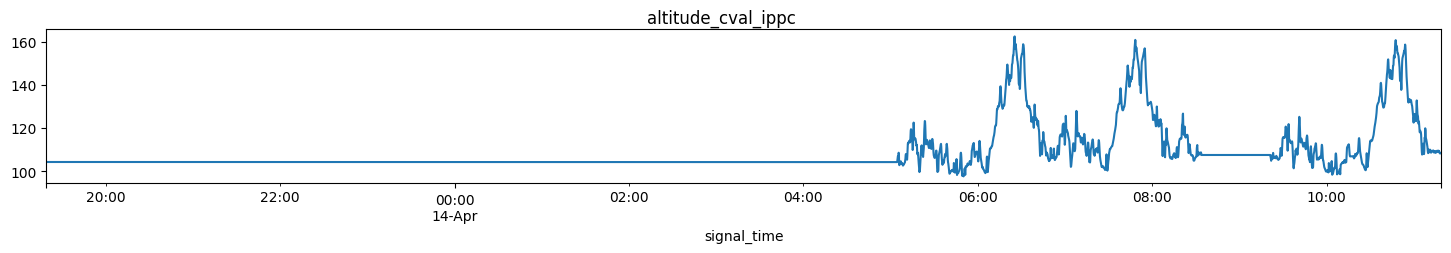

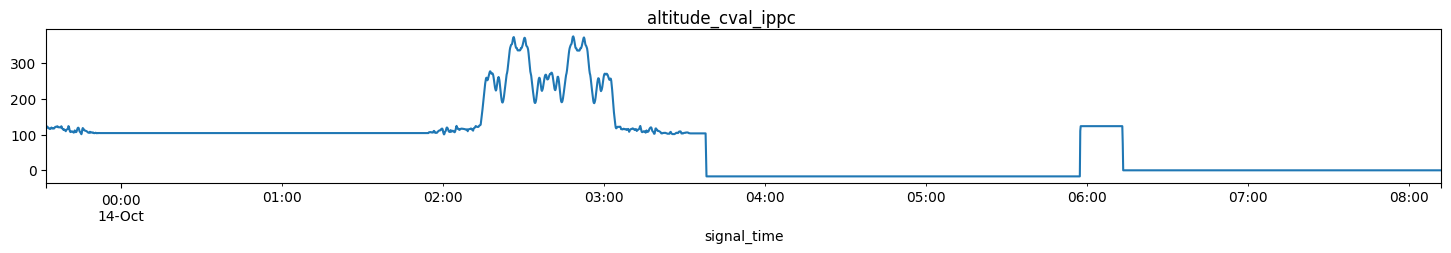

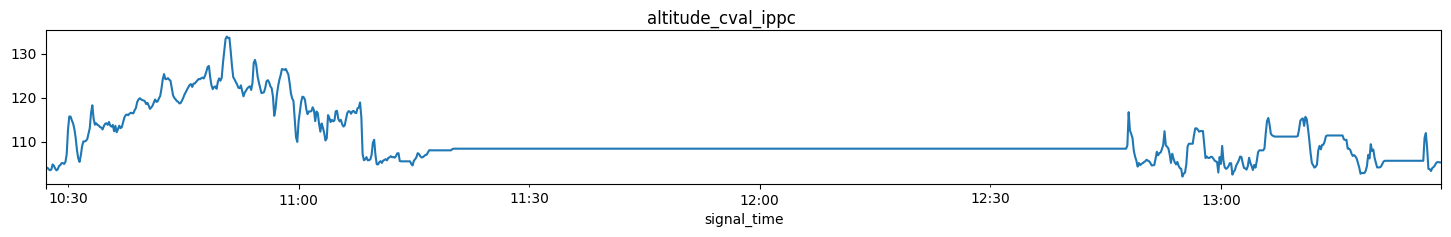

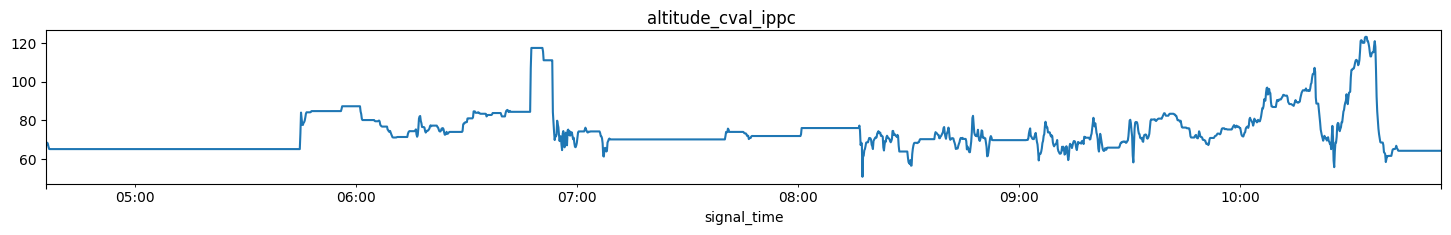

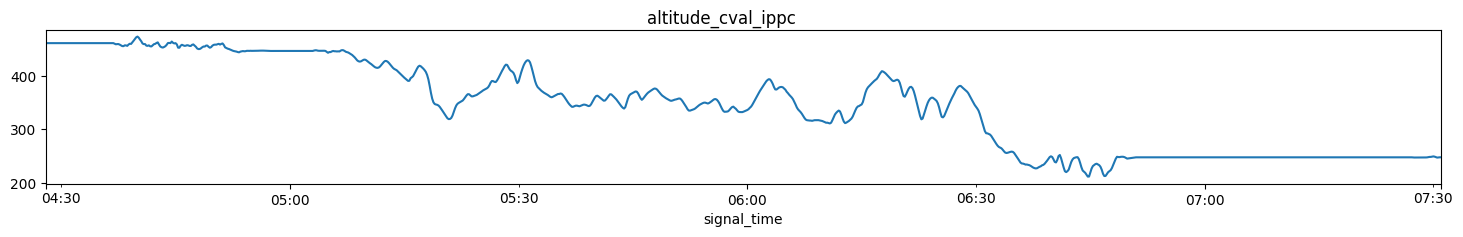

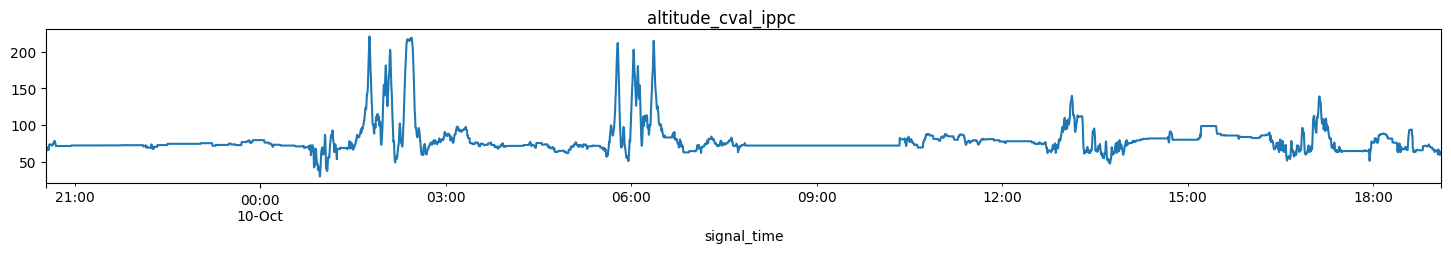

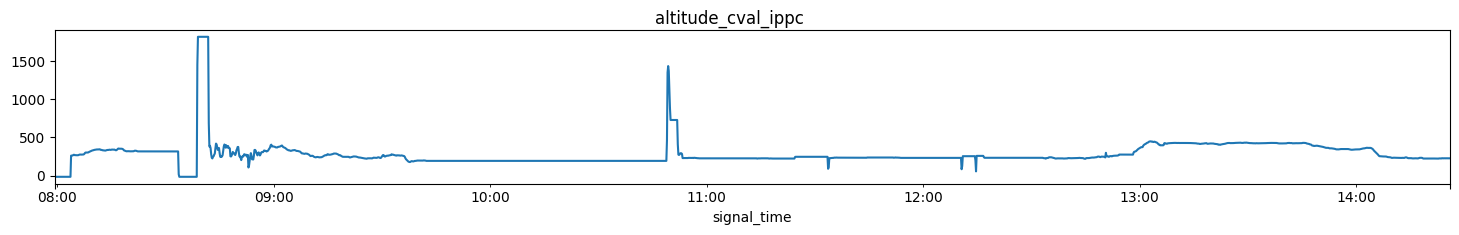

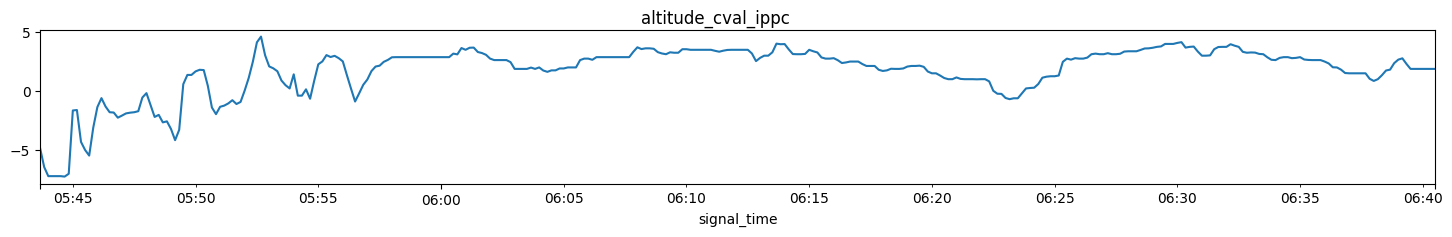

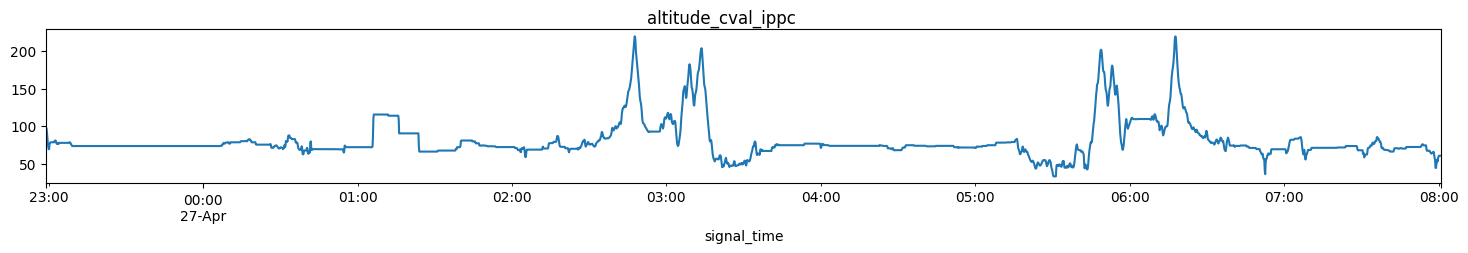

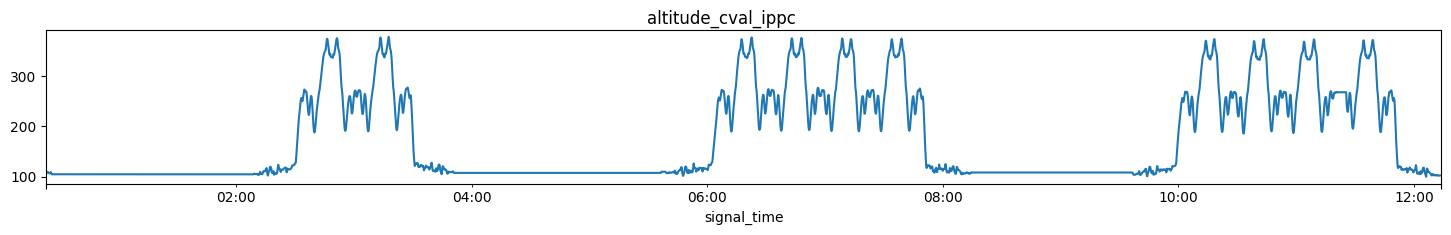

In [42]:
import matplotlib.pyplot as plt
import random

samples = random.sample(trips, 10)
signal  = random.choice(columns)

for f in samples:
    df = pd.read_parquet(Path(parquet_folder_resampled, f), engine='fastparquet')
    _ = df[signal].plot(figsize=(18, 2), subplots=True, title=signal)
    plt.show()



In [43]:
df

,accelpdlposn_cval,actdrvtrnpwrprc_cval,actualdcvoltage_pti1,actualdcvoltage_pti2,actualspeed_pti1,actualspeed_pti2,actualtorque_pti1,actualtorque_pti2,airtempinsd_cval_hvac,airtempinsd_rq,...,pt4_dcb_temp2_st3,rmsmotorcurrent_pti1,rmsmotorcurrent_pti2,roadgrad_cval_pt,selgr_rq_pt,signal_ts,stringvoltage_bms01,txoiltemp_cval_tcm,vehspd_cval_cpc,vehweight_cval_pt
signal_time,,,,,,,,,,,,,,,,,,,,,
2022-12-21 00:23:20,100.000,24.000,365.19000,365.400,6948.00,6948.5000,11.924029,11.912310,24.387500,23.0,...,13.0,92.9350,91.075000,2.160,1.00,1.671582e+15,366.3680,46.187500,27.816016,37.0
2022-12-21 00:23:30,96.716,23.680,365.06800,365.280,7261.64,7261.3900,11.126656,11.127203,24.550000,23.0,...,13.0,90.7525,88.690000,1.144,1.00,1.671582e+15,366.2616,46.196875,29.006758,37.0
2022-12-21 00:23:40,86.916,23.492,364.97000,365.212,4963.92,4964.8900,17.861765,17.827430,24.650938,23.0,...,13.0,137.4670,135.445500,0.448,1.67,1.671582e+15,366.6536,46.138750,32.943594,37.0
2022-12-21 00:23:50,25.800,13.394,365.61600,365.896,2863.74,2863.5700,15.485858,15.507342,24.375000,23.0,...,13.0,105.7385,104.638500,0.640,2.00,1.671582e+15,367.2600,46.200625,35.223789,37.0
2022-12-21 00:24:00,45.576,-36.104,369.70100,370.094,4310.26,4309.5100,-20.937074,-20.941879,24.160312,23.0,...,13.0,212.6635,213.124000,1.592,1.35,1.671582e+15,369.9468,46.311250,25.878516,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21 12:13:10,0.000,0.000,377.05400,377.478,-0.59,-0.5400,0.000041,-0.000897,25.339375,22.0,...,23.0,0.3080,0.316500,0.800,0.00,1.671625e+15,378.0836,52.750937,0.000000,37.0
2022-12-21 12:13:20,0.000,0.000,377.03100,377.474,-0.56,-0.4200,-0.001366,-0.001366,25.383750,22.0,...,23.0,0.3065,0.318000,0.800,0.00,1.671625e+15,378.0800,53.123750,0.000000,37.0
2022-12-21 12:13:30,0.000,0.000,377.03400,377.482,-0.54,-0.5000,0.000509,-0.000897,25.525000,22.0,...,23.0,0.3025,0.308000,0.800,0.00,1.671625e+15,378.0800,53.050000,0.000000,37.0
